# Torch Dataset Utilities

"torchdatasetutils" produces torch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) classes and utility functions for several imaging datasets.  This currently includes sets of images and annotations from [CVAT](https://github.com/openvinotoolkit/cvat), [COCO dataset](https://cocodataset.org/).  "torchdatasetutil" uses an s3 object storage to hold dataset data.  This enables training and test to be performed on nodes different from where the dataset is stored with application defined credentials.  It uses torch PyTorch worker threads to prefetch data for efficient GPU or CPU training and inference.

"torchdatasetutils" takes as an input the [pymlutil](https://pypi.org/project/pymlutil/).s3 object to access the object storage.

Two json or yaml dictionaries are loaded from the object storage to identify and process the dataset: the dataset description and class dictionary.  The the dataset description is unique for each type of dataset.  The class dictionary is common to all datasets and describes data transformation and data augmentation.

## Library structure
- pymlutil.s3: access to object torage
- [torchdatasetutil](https://pypi.org/project/torchdatasetutil/)
    - [gitcoco.getcoco](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/getcoco.py#L25): function to load the [COCO dataset](https://cocodataset.org/) from internet archives into object storage
    - [cocostore](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/cocostore.py)
        - [CocoStore](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/cocostore.py#L17): class providing a python iterator over the coco dataset in object storage
        - [CocoDataset](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/cocostore.py)" class implementing the pytorch [Dataset class](https://pytorch.org/docs/stable/data.html#dataset-types) for the CocoStore iterator
        - CreateCocoLoaders: function returning set of torch dataloders of CocoDatasets.
    - [imstore](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/imstore.py)
        - ImagesStore: class providing python iterator over sets of images for dataset inference.
        - ImagesDataset: Torch dataset derived class augmenting and extaracting random crops for training and test.
        - CreateImageLoaders: function returning set of torch dataloaders of ImagesDatasets.


In [1]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
from pymlutil.s3 import s3store, Connect
from torchdatasetutil.imstore import ImagesStore, CreateImageLoaders
from torchdatasetutil.cocostore import CocoStore, CreateCocoLoaders

In [2]:
credentials = "creds.yaml"
s3, creds, s3def = Connect(credentials)
s3def

{'name': 'store',
 'type': 'trainer',
 'address': '198.211.145.1:30990',
 'tls': False,
 'sets': {'dataset': {'bucket': 'mllib',
   'prefix': 'data',
   'dataset_filter': ''},
  'trainingset': {'bucket': 'mllib',
   'prefix': 'training',
   'dataset_filter': ''},
  'model': {'bucket': 'mllib', 'prefix': 'model', 'dataset_filter': ''},
  'test': {'bucket': 'mllib', 'prefix': 'test', 'dataset_filter': ''}}}

## Create images dataset


In [3]:
! python3 -m pymlutil -p -src tests/testimages -set dataset -dest testimages

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 111.08it/s]
pymluitil complete


### imstore dataset
torchdatasetutil.imstore ImagesStore produces an [iterator object](https://docs.python.org/3/c-api/iterator.html) from a set of images in an object store.  The image dataset_description is a json or yaml file definining the set of images to include in the ImageStore.

In [4]:
bucket = s3def['sets']['dataset']['bucket']
img_dataset_desc_file = 'annotations/lit/dataset.yaml'
img_dataset_desc = s3.GetDict(bucket,img_dataset_desc_file)
img_dataset_desc

{'bucket': 'mllib',
 'prefix': 'annotations/lit',
 'image_path': None,
 'image_pattern': '*.tif',
 'image_colorspace': 'grayscale',
 'label_path': None,
 'label_in_image_path': True,
 'label_pattern': '*_cls.png',
 'recursive': True}

### Class Dictionary

"torchdatasetloader" expects a class_dictionary input.  The class dictionary defines a mapping between the dataset classes and the training classes.  "class_dictionary" has the following entries:
```json
{
    'background': <background index>
    'ignore': <ignore index>
    'objects'[
        {
            'id': <dataset integer class index>
            'trainId': <training integer class index>
            'name': <string class name>
            'category': <string group name>
            'display': <true/false>
            'color':[<red:0-255>,<green:0-255>, <blue:0-255>]
        },
        ...
    ]
}
```

In [5]:
class_dictionary = 'model/crisplit/lit.json'
class_dictionary_example = s3.GetDict(s3def['sets']['dataset']['bucket'],class_dictionary)
class_dictionary_example

{'background': 0,
 'ignore': 255,
 'classes': 2,
 'objects': [{'id': 0,
   'name': 'unlabeled',
   'trainId': 0,
   'category': 'void',
   'display': False,
   'color': [0, 0, 0]},
  {'id': 1,
   'name': 'FibLine',
   'trainId': 1,
   'category': 'vehicle',
   'display': True,
   'color': [255, 0, 0]},
  {'id': 9,
   'name': 'FibLine',
   'trainId': 1,
   'category': 'vehicle',
   'display': True,
   'color': [255, 0, 0]}]}

In [13]:
def DisplayImages(store, num_images=4, columns=2, sizeX=10, sizeY=10):

    plt.figure(figsize=(sizeX,sizeY))

    for i, iman in enumerate(store):
        img = store.MergeIman(iman['img'], iman['ann'])
        plt.subplot(int(num_images / columns + 1), columns, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.tight_layout()
        if i >= num_images-1:
            break

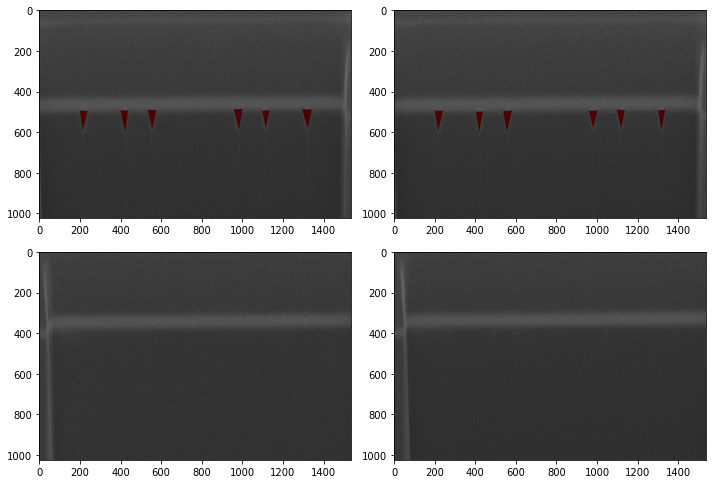

In [14]:
store = ImagesStore(s3, bucket, img_dataset_desc_file, class_dictionary)
DisplayImages(store)

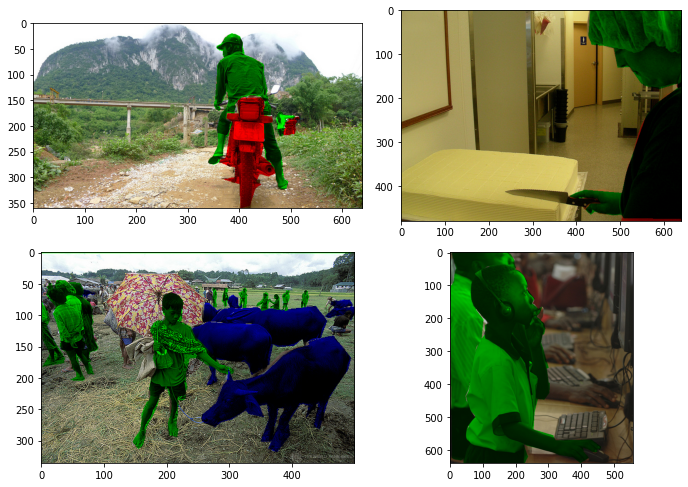

In [15]:
dataset_train= 'data/coco/annotations/instances_train2017.json'
dataset_val= 'data/coco/annotations/instances_val2017.json'
train_image_path= 'data/coco/train2017'
val_image_path= 'data/coco/val2017'
class_dict= 'model/segmin/coco.json'

store = CocoStore(s3, bucket=bucket, 
                    dataset_desc=dataset_train, 
                    image_paths=train_image_path, 
                    class_dictionary=class_dict)

DisplayImages(store)